In [1]:
"""
Author: Aishik Ghosh, Elham E Khoda
"""

'\nAuthor: Aishik Ghosh, Elham E Khoda\n'

# Standard library imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Generate data:
Input Features: $X_1, X_2$

Target: $Y_1, Y_2$

$Y_1 = X_1 \cos(X_2)$; $Y_2 = X_1 \sin(X_2)$

In [3]:
n_events = 2 * 10**6  # dataset size
feature_std = 5

In [4]:
X1, X2 = (
    np.random.normal(0, feature_std, (n_events, 1)),
    np.random.uniform(-np.pi, np.pi, (n_events, 1)),
)
X = np.concatenate([X1, X2], axis=1)
Y1, Y2 = X1 * np.cos(X2), X1 * np.sin(X2)

In [5]:
# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
scaler.mean_, scaler.var_

(array([ 0.00295778, -0.00063002]), array([25.02020623,  3.29114553]))

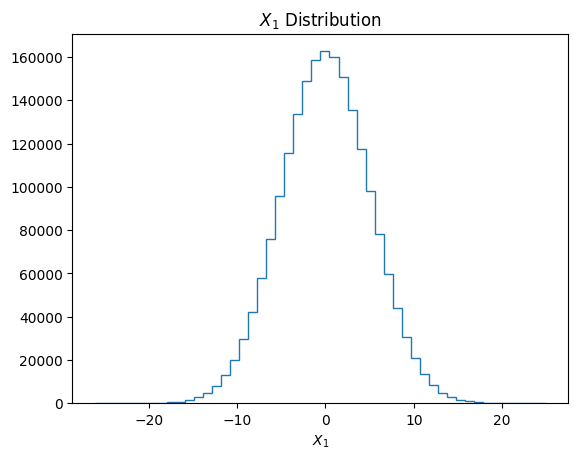

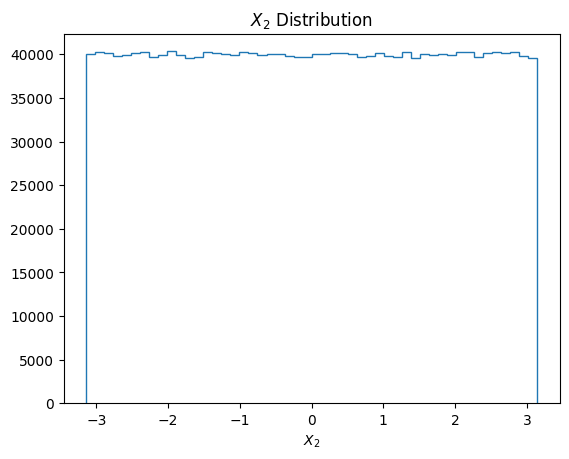

In [6]:
# plot input features

plt.hist(X1, bins=50, histtype="step")
plt.xlabel("$X_1$")
plt.title("$X_1$ Distribution")
plt.show()
plt.hist(X2, bins=50, histtype="step")
plt.xlabel("$X_2$")
plt.title("$X_2$ Distribution")
plt.show()

# TF.Keras Neural Network

In [7]:
# simple dense network

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, LeakyReLU
from tensorflow.keras.models import Model

n_hidden = 3
n_nodes = 32

inputs = Input(shape=(X.shape[1],))
hidden = Dense(n_nodes, activation="relu")(inputs)

for i in range(n_hidden - 1):
    hidden = Dense(n_nodes)(hidden)
    hidden = LeakyReLU()(hidden)
predictionY1 = Dense(1, activation="linear")(hidden)

simple_model = Model(inputs=inputs, outputs=predictionY1)
simple_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

2023-07-28 10:19:47.535761: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 10:19:49.703162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38228 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-07-28 10:19:49.708994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38228 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-07-28 10:19:49.710596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/devi

In [8]:
simple_model.fit(x=X_scaled, y=Y1, epochs=5, batch_size=1024)

2023-07-28 10:19:50.917947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
 162/1954 [=>............................] - ETA: 1s - loss: 8.6768 

2023-07-28 10:19:51.796507: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1954/1954 [==============================] - 2s 856us/step - loss: 0.8153
Epoch 2/5
1954/1954 [==============================] - 2s 848us/step - loss: 0.0058
Epoch 3/5
1954/1954 [==============================] - 2s 831us/step - loss: 0.0041
Epoch 4/5
1954/1954 [==============================] - 2s 818us/step - loss: 0.0034
Epoch 5/5
1954/1954 [==============================] - 2s 814us/step - loss: 0.0030


In [9]:
Y1_pred = simple_model.predict(X_scaled, batch_size=1024 * 4).ravel()

In [10]:
mean_squared_error(y_pred=Y1_pred, y_true=Y1)

0.006338667936040781

## Save NN model
### Note: not in HDF5 format

In [11]:
simple_model.save("simple_model")

2023-07-28 10:20:00.392144: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: simple_model/assets


# Convert to onnx format
## Note: use tf2onnx not keras2onnx

Using "!" allows you to run unix command on terminal

In [12]:
!pip install tf2onnx

Defaulting to user installation because normal site-packages is not writeable
  Using cached tf2onnx-1.14.0-py3-none-any.whl (451 kB)
  Using cached onnx-1.14.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.6 MB)
  Using cached protobuf-4.23.4-cp37-abi3-manylinux2014_x86_64.whl (304 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.7.1 which is incompatible.
tensorflow-metadata 1.12.0 requires protobuf<4,>=3.13, but you have protobuf 4.23.4 which is incompatible.
tensorboardx 2.5.1 requires protobuf<=3.20.1,>=3.8.0, but you have protobuf 4.23.4 which is incompatible.
tensorboard 2.11.0 requires protobuf<4,>=3.9.2, but you have protobuf 4.23.4 which is incompatible.


In [13]:
!python -m tf2onnx.convert --saved-model simple_model/ --output simple_model.onnx

Traceback (most recent call last):
  File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/runpy.py", line 188, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/runpy.py", line 111, in _get_module_details
    __import__(pkg_name)
  File "/global/homes/e/elham/.local/perlmutter/tensorflow2.6.0/lib/python3.9/site-packages/tf2onnx/__init__.py", line 10, in <module>
    from . import verbose_logging as logging
  File "/global/homes/e/elham/.local/perlmutter/tensorflow2.6.0/lib/python3.9/site-packages/tf2onnx/verbose_logging.py", line 14, in <module>
    import tensorflow as tf
  File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/tensorflow/__init__.py", line 41, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "/global/common/software/nersc/pm-2022q4/sw/tensorfl

# Load model in ONNX RT for inference

In [15]:
import onnxruntime

sess = onnxruntime.InferenceSession(
    "simple_model.onnx",
)
input_names = sess.get_inputs()


def pred_ONNX_simple(X):
    #
    # Mimic any training pre-preocessing here
     Write your code here!
    #

    data = [x.astype(np.float32) for x in X]
    feed = zip(sorted(i_.name for i_ in input_names), data)
    pred = sess.run(None, dict(feed))
    return pred


# could turn off multi-threading etc
# sess_options = onnxruntime.SessionOptions()
# sess = onnxruntime.InferenceSession("simple_model.onnx", sess_options)
# sess_options.inter_op_num_threads = 1
# sess_options.intra_op_num_threads = 1
# sess_options.execution_mode = rt.ExecutionMode.ORT_SEQUENTIAL
# sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_ALL

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 15)

## Similar helper function for Keras model prediction

In [ ]:
from tensorflow.keras.models import load_model

simple_model = load_model("simple_model")


def pred_Keras_simple(
    X,
):
    #
    # Mimic any training pre-preocessing here
    Write your code here!
    #
    return simple_model.predict(X, batch_size=1024)

In [ ]:
y1_pred_k = pred_Keras_simple([X])
y1_pred_k[:5]

In [ ]:
# X is expected to be a list of inputs, if only one, pass [X]
# output is a list of size 1
y1_pred_o = pred_ONNX_simple([X])[0]
y1_pred_o[:5]

In [ ]:
print(
    "ORT & Keras values same for all Y1: ",
    np.isclose(y1_pred_k, y1_pred_o, atol=1e-05).all(),
)

In [ ]:
print(
    "MSE for Keras: ",
    mean_squared_error(y_pred=y1_pred_k, y_true=Y1),
)
print(
    "MSE for ORT: ",
    mean_squared_error(y_pred=y1_pred_o, y_true=Y1),
)

# Handling Custom layers 

LWTNN cannot handle new custom layers but we will see that ONNX can



## Example Custum layer : Dense layer with tanh on bias

In [ ]:
from tensorflow import keras
import tensorflow as tf


class CustomLayer(keras.layers.Layer):
    """
    Custom Dense Layer that applies a tanh on bias
    """

    def __init__(self, units=32):
        super(CustomLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="b", shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + tf.math.tanh(self.b)

Now also handle multiple inputs to and outputs from network

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, LeakyReLU
from tensorflow.keras.models import Model

n_hidden = 3
n_nodes = 32  # 256

input1 = Input(shape=(X1.shape[1],))
input2 = Input(shape=(X2.shape[1],))
inputs = Concatenate(axis=-1)([input1, input2])
hidden = Dense(n_nodes, activation="relu")(inputs)

for i in range(n_hidden - 1):
    hidden = CustomLayer(n_nodes)(hidden)
    hidden = LeakyReLU()(hidden)
predictionY1 = Dense(1, activation="linear")(hidden)
predictionY2 = Dense(1, activation="linear")(hidden)

custom_model = Model(inputs=[input1, input2], outputs=[predictionY1, predictionY2])
custom_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

In [ ]:
custom_model.summary()

In [ ]:
custom_model.fit(x=[X1, X2], y=[Y1, Y2], epochs=1, batch_size=1024)

In [ ]:
Y1_pred, Y2_pred = custom_model.predict([X1, X2], batch_size=1024 * 4)
Y1_pred, Y2_pred = Y1_pred.ravel(), Y2_pred.ravel()

In [ ]:
mean_squared_error(y_pred=Y1_pred, y_true=Y1), mean_squared_error(
    y_pred=Y2_pred, y_true=Y2
),

### Save customl model

In [ ]:
custom_model.save("custom_model")

### Convert to onnx format

In [ ]:
Write your code here!

## Load model in ONNX RT for inference

In [ ]:
import onnxruntime

sess = onnxruntime.InferenceSession(
    "custom_model.onnx",
)
input_names = sess.get_inputs()


def pred_ONNX(X):
    #
    # Mimic any training pre-preocessing here
    #

    data = [x.astype(np.float32) for x in X]
    feed = zip(sorted(i_.name for i_ in input_names), data)
    pred = sess.run(None, dict(feed))
    return pred


# could turn off multi-threading etc
# sess_options = onnxruntime.SessionOptions()
# sess = onnxruntime.InferenceSession("custom_model.onnx", sess_options)
# sess_options.inter_op_num_threads = 1
# sess_options.intra_op_num_threads = 1
# sess_options.execution_mode = rt.ExecutionMode.ORT_SEQUENTIAL
# sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_ALL

## Similar functions for Keras model prediction

In [ ]:
from tensorflow.keras.models import load_model

custom_model = load_model("custom_model")


def pred_Keras(X):
    #
    # Mimic any training pre-preocessing here
    #

    return custom_model.predict(X, batch_size=1024)

## Predict and compare ORT to Keras

In [ ]:
y1_pred_k, y2_pred_k = pred_Keras([X1, X2])
y1_pred_k[:5]

In [ ]:
# X is expected to be a list of inputs, if only one, pass [X]
y1_pred_o, y2_pred_o = pred_ONNX([X1, X2])
y1_pred_o[:5]

In [ ]:
print(
    "ORT & Keras values same for all Y1: ",
    np.isclose(y1_pred_k, y1_pred_o, atol=1e-05).all(),
    "\nORT & Keras values same for all Y2: ",
    np.isclose(y2_pred_k, y2_pred_o, atol=1e-05).all(),
)

In [ ]:
print(
    "MSE for Keras: ",
    mean_squared_error(y_pred=y1_pred_k, y_true=Y1),
    mean_squared_error(y_pred=y2_pred_k, y_true=Y2),
)
print(
    "MSE for ORT: ",
    mean_squared_error(y_pred=y1_pred_o, y_true=Y1),
    mean_squared_error(y_pred=y2_pred_o, y_true=Y2),
)

## Timing comparisons

In [ ]:
l = 15

In [ ]:
%%time
for i in range(l):
    _ = pred_Keras([X1, X2])

In [ ]:
%%time
Write your code here!
    

#### Bonus: A less known, faster way to evaluate with keras

In [ ]:

def pred_KerasNoTrain(X):
    #
    # Mimic any training pre-preocessing here
    #

    return custom_model(X, training=False)

In [ ]:
%%time
for i in range(l):
    _ = pred_KerasNoTrain([X1, X2])

# Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()
print(net)


criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_data = []
Y = np.concatenate([Y1, Y2], axis=1).astype(np.float32)
for i in range(len(X) // 10):  # take 1/10 to run faster
    train_data.append([X[i].astype(np.float32), Y[i]])

trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=512, shuffle=True, num_workers=1
)

In [ ]:
for epoch in range(1):  # loop over the dataset

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Finished Training")

In [ ]:
# evluation mode
net.eval()

In [ ]:
torch_outs = net(torch.from_numpy(X).float()).detach().numpy()

## Convert to ONNX

Allow batch size to remain dynamic

In [ ]:
batch_size = 1
inT = torch.randn(batch_size, X.shape[1])

torch.onnx.export(
    model=net,
    args=(inT),
    f="savedModels/pytorch_net.onnx",
    input_names=["X"],
    output_names=["Y"],
    dynamic_axes={'X' : {0 : 'batch_size'},    # variable lenght axes
                                'Y' : {???? : 'batch_size'}}, Write your code here!
    opset_version=16,
)

# Run model with onnx rumtime

no sorting of input names this time

In [ ]:
import onnxruntime
sess = onnxruntime.InferenceSession(???,) Write your code here!
input_names = sess.get_inputs()
output_names = sess.get_outputs()


def pred_ONNX_2(X):
    data = [x.astype(np.float32) for x in X]
    inputFeed = zip([i_.name for i_ in input_names], data)
    outputNames = [i_.name for i_ in output_names]

    pred = sess.run(output_names=outputNames, input_feed=dict(inputFeed))
    return pred


# could turn off multi-threading etc
# sess_options = onnxruntime.SessionOptions()
# sess = onnxruntime.InferenceSession("custom_model.onnx", sess_options)
# sess_options.inter_op_num_threads = 1
# sess_options.intra_op_num_threads = 1
# sess_options.execution_mode = rt.ExecutionMode.ORT_SEQUENTIAL
# sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_ALL

In [ ]:
pred_ONNX_2([X[:5]])

In [ ]:
torch_outs[:5]

# Homework: Timing comparisons for torch vs onnx